#  Gene Sets and Expression for Tumor vs. Normal and Tissue Classification

Use gene sets from [MSigDB](http://software.broadinstitute.org/gsea/msigdb) to both prune the number of genes/features as well as a source of pathway information to encorporate into layer design.

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras

# fix random seed for reproducibility
np.random.seed(42)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%%time
# Load samples and labels
X = pd.read_hdf("data/TcgaTargetGtex_RSEM_Hugo_norm_count.hd5", "expression")
print("X: samples={} genes={}".format(*X.shape))

Y = pd.read_table("data/TcgaTargetGTEX_phenotype.txt.gz", compression="gzip", header=0,
                      names=["id", "category", "disease", "primary_site", "sample_type", "gender", "study"],
                      sep="\t", encoding="ISO-8859-1", index_col=0, dtype="str")
print("Y: samples={} labels={}".format(*Y.shape))

X: samples=19249 genes=58581
Y: samples=19131 labels=6
CPU times: user 880 ms, sys: 3.58 s, total: 4.46 s
Wall time: 4.48 s


In [3]:
# Sort so indexes match
X.sort_index(axis=0, inplace=True)
X.sort_index(axis=1, inplace=True)
Y.sort_index(axis=0, inplace=True)

# Remove rows where the class is null or the sample is missing
intersection = X.index.intersection(Y[pd.notnull(Y["primary_site"])].index)
X = X[X.index.isin(intersection)]
Y = Y[Y.index.isin(intersection)]

# Make sure the label and example samples are in the same order
assert(X.index.equals(Y.index))

print(intersection.shape[0], "samples with non-null labels")

19115 samples with non-null labels


In [4]:
# Compute and add a tumor/normal column - TCGA and TARGET have some normal samples, GTEX is all normal.
Y.loc[:, "tumor_normal"] = Y.apply(
    lambda row: "Normal" if row["sample_type"] in ["Cell Line", "Normal Tissue", "Solid Tissue Normal"]
    else "Tumor", axis=1)

# Convert tumor_normal and primary_site into numerical values for two-hot multi-class training
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
Y["tumor_normal_value"] = pd.Series(encoder.fit_transform(Y["tumor_normal"]), index=Y.index)
encoder = LabelEncoder()
Y["primary_site_value"] = pd.Series(encoder.fit_transform(Y["primary_site"]), index=Y.index)
Y.describe(include="all", percentiles=[])

,category,disease,primary_site,sample_type,gender,study,tumor_normal,tumor_normal_value,primary_site_value
count,19115,19115,19115,19115,18957,19115,19115,19115.000000,19115.000000
unique,93,93,46,16,2,3,2,NaN,NaN
top,Breast Invasive Carcinoma,Breast Invasive Carcinoma,Brain,Primary Tumor,Male,TCGA,Tumor,NaN,NaN
freq,1212,1212,1835,9185,10447,10534,10530,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.550876,20.659273
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.497418,12.419497
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,19.000000
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,45.000000


In [5]:
X[0:20000:3000].head()

sample,5S_rRNA,5_8S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,...,snoU2-30,snoU2_19,snoU83B,snoZ196,snoZ278,snoZ40,snoZ6,snosnR66,uc_338,yR211F11.2
GTEX-1117F-0226-SM-5GZZ7,0.0,0.0,0.0,7.3524,6.1269,1.9343,14.432300,6.5937,4.6431,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000
GTEX-145LS-1226-SM-5Q5D9,0.0,0.0,0.0,6.4274,6.8759,1.0336,18.091999,6.6323,2.0501,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000
GTEX-X8HC-0126-SM-4E3JW,0.0,0.0,0.0,7.1905,7.3925,1.8230,13.508500,4.3042,11.9234,1.823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.1821,0.0000
TCGA-24-1436-01,0.0,0.0,0.0,7.8777,8.3273,0.0000,14.739500,6.5108,5.7128,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,1.6946
TCGA-BG-A3PP-01,0.0,0.0,0.0,5.4354,5.4573,0.0000,13.103800,5.9861,7.4694,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000


In [6]:
Y[0:20000:3000].head()

,category,disease,primary_site,sample_type,gender,study,tumor_normal,tumor_normal_value,primary_site_value
id,,,,,,,,,
GTEX-1117F-0226-SM-5GZZ7,Adipose - Subcutaneous,Adipose - Subcutaneous,Adipose Tissue,Normal Tissue,Female,GTEX,Normal,0,0
GTEX-145LS-1226-SM-5Q5D9,Lung,Lung,Lung,Normal Tissue,Female,GTEX,Normal,0,22
GTEX-X8HC-0126-SM-4E3JW,Skin - Sun Exposed (Lower Leg),Skin - Sun Exposed (Lower Leg),Skin,Normal Tissue,Female,GTEX,Normal,0,33
TCGA-24-1436-01,Ovarian Serous Cystadenocarcinoma,Ovarian Serous Cystadenocarcinoma,Ovary,Primary Tumor,Female,TCGA,Tumor,1,26
TCGA-BG-A3PP-01,Uterine Corpus Endometrioid Carcinoma,Uterine Corpus Endometrioid Carcinoma,Endometrium,Primary Tumor,Female,TCGA,Tumor,1,13


In [7]:
# Load gene sets from downloaded MSigDB gmt file (KEGG to for now as its experimental vs. computational)
with open("data/c2.cp.kegg.v6.1.symbols.gmt") as f:
    gene_sets = { line.strip().split("\t")[0]: line.strip().split("\t")[2:] for line in f.readlines()}
print("Loaded {} gene sets".format(len(gene_sets)))

# Drop any genes that are not in X - sort so that the order is the same as X_pruned.columns
gene_sets = {name: sorted([gene for gene in genes if gene in X.columns.values]) 
             for name, genes in gene_sets.items()}

# Find the union of all gene's in the gene sets in order to filter our input rows
all_gene_set_genes = sorted(list(set().union(*[gene_set for gene_set in gene_sets.values()])))
print("Subsetting to {} genes".format(len(all_gene_set_genes)))

# Prune X to only include genes in the gene sets
X_pruned = X.drop(labels=(set(X.columns) - set(all_gene_set_genes)), axis=1, errors="ignore")
assert X_pruned["TP53"]["TCGA-ZP-A9D4-01"] == X["TP53"]["TCGA-ZP-A9D4-01"]
print("X_pruned shape", X_pruned.shape)

Loaded 186 gene sets
Subsetting to 5172 genes
X_pruned shape (19115, 5172)


In [8]:
# Make sure the genes are the same and in the same order
assert len(all_gene_set_genes) == len(X_pruned.columns.values)
assert list(X_pruned.columns.values) == all_gene_set_genes

In [9]:
# Create a multi-label output with tumor/normal + primary site one-hots
from keras.utils import np_utils
primary_site_one_hot = np_utils.to_categorical(Y["primary_site_value"])
tumor_normal_one_hot = Y["tumor_normal_value"]
Y_multiclass_onehot = np.append(
    tumor_normal_one_hot.values.reshape(tumor_normal_one_hot.shape[0],-1), 
    primary_site_one_hot, axis=1)
print(Y_multiclass_onehot.shape)
print(Y_multiclass_onehot[0:20000:5000])

(19115, 47)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [10]:
# Split into stratified training and test sets based on classes (i.e. tissue type) so that we have equal
# proportions of each tissue type in the train and test sets
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_pruned.values, Y["tumor_normal_value"]):
    X_train, X_test = X_pruned.values[train_index], X_pruned.values[test_index]
    y_train, y_test = Y_multiclass_onehot[train_index], Y_multiclass_onehot[test_index]
    classes_train, classes_test = Y["primary_site_value"].values[train_index], Y["primary_site_value"].values[test_index]

print(X_train.shape, X_test.shape)

(15292, 5172) (3823, 5172)


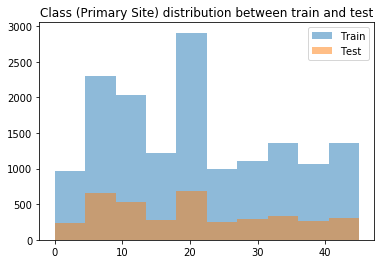

In [11]:
# Plot histogram of  train vs. test classes to verify stratification of train vs. test
import matplotlib.pyplot as pyplot
pyplot.hist(classes_train, alpha=0.5, label='Train')
pyplot.hist(classes_test, alpha=0.5, label='Test')
pyplot.legend(loc='upper right')
pyplot.title("Class (Primary Site) distribution between train and test")
pyplot.show()

In [12]:
"""
Binary tumor/normal classification with union of genes from all gene sets as input
"""
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

epochs=10
batch_size=128

classify = [
    InputLayer(input_shape=(X_train.shape[1],)),
    BatchNormalization(),

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(8, activity_regularizer=regularizers.l1(1e-5), activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
]

model = Sequential(classify)
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks=[EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max")]
model.fit(X_train, y_train[:,0], epochs=epochs, batch_size=batch_size, shuffle="batch", callbacks=callbacks)

print(model.metrics_names, model.evaluate(X_test, y_test[:,0]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5172)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5172)              20688     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                165536    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total para

In [13]:
%%time
"""
Multi-label classification of tumor/normal + primary site with union of genes from all gene sets as input
"""
from keras.models import Model, Sequential
from keras.layers import InputLayer, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers

epochs=10
batch_size=128

classify = [
    InputLayer(input_shape=(X_train.shape[1],)),
    BatchNormalization(),

    Dense(32, activation='relu'),
    Dropout(0.5),

    Dense(16, activity_regularizer=regularizers.l1(1e-5), activation='relu'),
    Dropout(0.5),
    
    Dense(y_train.shape[1], activation='sigmoid')
]

model = Sequential(classify)
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks=[EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max")]
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle="batch", callbacks=callbacks)

print(model.metrics_names, model.evaluate(X_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5172)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 5172)              20688     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                165536    
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 47)                799       
Total para

In [14]:
# Convert list of gene names into list of indexes into the features of X_pruned
gene_set_indexes = {name: np.searchsorted(X_pruned.columns.values, genes) for name, genes in gene_sets.items()}
print("Pathway KEGG_ABC_TRANSPORTERS Gene Indexes:", gene_set_indexes["KEGG_ABC_TRANSPORTERS"])

Pathway KEGG_ABC_TRANSPORTERS Gene Indexes: [  11   12   13   14   15   16   17   18   19   20   21   22   23   24
   25   26   27   28   29   30   31   32   33   34   35   36   37   38
   39   40   41   42   43   44   45   46   47   48   49   50   51  848
 4692 4693]


In [15]:
%%time
"""
Multi-label classification of tumor/normal + primary site by building a sub-network per
pathway with hidden per pathway binary output layer that's named for the pathway 
which 'may' indicate which pathway led to the classification.
"""
from keras.models import Model, Sequential
from keras.layers import Input, Lambda, Dense, BatchNormalization, Activation, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.layers.merge import concatenate
from keras import backend as K
import itertools


main_input = Input(shape=(X_train.shape[1],), name="main_input")

"""
Build per pathway sub-networks
"""
# Set to a small number (~4) for debugging, set to None to build all pathways
# max_num_pathways = 4 
max_num_pathways = None 

# Extract the features/gene's for each pathway from the aggregate x input vector
pathways = [Lambda(lambda x: K.concatenate([x[:, i:i+1] for i in indexes]))(main_input)
            for name, indexes in itertools.islice(gene_set_indexes.items(), max_num_pathways)]

# Add a dense hidden layer per pathway with width proportional to the number of genes in the pathway
# pathways = [Dense(max(2, len(i)//4), activation='relu')(p) for p, i in zip(pathways, gene_set_indexes.values())]

# Add a final binary output for each pathway and name it - these hidden neurons 'may'
# indicate which pathways had the most influence on the classifications
pathways = [Dense(1, activation='relu', name=name)(p) for p, name in zip(pathways, gene_set_indexes.keys())]

# Concatenate the binary outputs of each of the sub-networks back into a single vector
x = keras.layers.concatenate(pathways)
           

"""
Traditional single stacked network for final multi-label classification
"""
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
    
x = Dense(8, activity_regularizer=regularizers.l1(1e-5), activation='relu')(x)
x = Dense(y_train.shape[1], activation='sigmoid')(x)

model = Model(inputs=[main_input], outputs=[x])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 5172)         0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 61)           0           main_input[0][0]                 
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 30)           0           main_input[0][0]                 
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 26)           0           main_input[0][0]                 
__________________________________________________________________________________________________
lambda_4 (

KEGG_STEROID_BIOSYNTHESIS (Dens (None, 1)            17          lambda_9[0][0]                   
__________________________________________________________________________________________________
KEGG_PRIMARY_BILE_ACID_BIOSYNTH (None, 1)            17          lambda_10[0][0]                  
__________________________________________________________________________________________________
KEGG_STEROID_HORMONE_BIOSYNTHES (None, 1)            56          lambda_11[0][0]                  
__________________________________________________________________________________________________
KEGG_OXIDATIVE_PHOSPHORYLATION  (None, 1)            119         lambda_12[0][0]                  
__________________________________________________________________________________________________
KEGG_PURINE_METABOLISM (Dense)  (None, 1)            156         lambda_13[0][0]                  
__________________________________________________________________________________________________
KEGG_PYRIM

                                                                 KEGG_TIGHT_JUNCTION[0][0]        
                                                                 KEGG_GAP_JUNCTION[0][0]          
                                                                 KEGG_COMPLEMENT_AND_COAGULATION_C
                                                                 KEGG_ANTIGEN_PROCESSING_AND_PRESE
                                                                 KEGG_RENIN_ANGIOTENSIN_SYSTEM[0][
                                                                 KEGG_TOLL_LIKE_RECEPTOR_SIGNALING
                                                                 KEGG_NOD_LIKE_RECEPTOR_SIGNALING_
                                                                 KEGG_RIG_I_LIKE_RECEPTOR_SIGNALIN
                                                                 KEGG_CYTOSOLIC_DNA_SENSING_PATHWA
                                                                 KEGG_JAK_STAT_SIGNALING_PATHWAY[0
          

In [16]:
%%time
epochs=10
batch_size=128

print("Compiling...")
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Training...")
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle="batch", 
          callbacks=[EarlyStopping(monitor='acc', min_delta=0.05, patience=2, verbose=2, mode="max")])
print("Evaluating...")
print(model.metrics_names, model.evaluate(X_test, y_test))

Compiling...
Training...
Epoch 1/10
15292/15292 [==============================] - 85s 6ms/step - loss: 0.5903 - acc: 0.8396
Epoch 2/10
15292/15292 [==============================] - 19s 1ms/step - loss: 0.2410 - acc: 0.9520
Epoch 3/10
15292/15292 [==============================] - 18s 1ms/step - loss: 0.1818 - acc: 0.9692
Epoch 4/10
15292/15292 [==============================] - 19s 1ms/step - loss: 0.1686 - acc: 0.9696
Epoch 00004: early stopping
Evaluating...
3823/3823 [==============================] - 52s 14ms/step
['loss', 'acc'] [0.12045093296032877, 0.970636899593517]
CPU times: user 5min 45s, sys: 51.6 s, total: 6min 37s
Wall time: 3min 38s
